In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB4

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
efficienNet = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(256,256,3))

In [4]:
print(efficienNet.layers[326].output.shape)
print(efficienNet.layers[149].output.shape)
print(efficienNet.layers[90].output.shape)
print(efficienNet.layers[31].output.shape)

(None, 16, 16, 960)
(None, 32, 32, 336)
(None, 64, 64, 192)
(None, 128, 128, 144)


# Modelo
https://www.nature.com/articles/s41598-022-12743-y/figures/2

In [18]:
def encoder_subblock(efNet_conection_output):
    x = layers.Conv2D(512,3, padding = 'same')(efNet_conection_output)
    x = residual_block(x)
    x = residual_block(x)
    x = layers.LeakyReLU()(x)
    return x


def efNet_conection(efNet_output):
    x1 = layers.LeakyReLU()(efNet_output)
    x2 = layers.MaxPool2D((2,2), padding = 'same')(x1)
    x3 = layers.Dropout(0.3)(x2)
    return x3


def decoder_subblock(encoder_output, prev_layer):
    # https://www.nature.com/articles/s41598-022-12743-y/figures/3
    unification = layers.concatenate([encoder_output, prev_layer])
    x1 = layers.Dropout(0.3)(unification)
    x2 = layers.Conv2D(3,3,padding = 'same')(x1)
    x3 = residual_block(x2)
    x3 = residual_block(x3)
    x4 = layers.LeakyReLU()(x3)
    return x4


def residual_block(prev_layer):
    path_1 = layers.LeakyReLU()(prev_layer)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.LeakyReLU()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_2 = layers.BatchNormalization()(prev_layer)
    return layers.concatenate([path_1, path_2])

    
def up_sampling(prev_layer, deep, kernel):
    x = layers.Conv2DTranspose(deep, kernel)(prev_layer)
    return x


def last_up_sampling(prev_layer):
    x = layers.Conv2D(1,3, padding='same', activation='sigmoid')(prev_layer)
    return x


No me deja añadir una capa inicial, porque sino efficienNet da error, necesita recibir un input.layer, sino cuando carga los pesoss dice que las capas no coinciden.

No he añadido el encoder sub block porque me da error

In [16]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(256,256,3))
    
    # adaptation = layers.Conv2D(3, 3, padding="same", activation = "elu")(inputs)
        
    #EfficientNet
    efficienNet = EfficientNetB4(weights="imagenet",
                                 include_top=False,
                                 input_shape=(256,256,3),
                                 input_tensor=inputs)
    
    efficienNet.trainable = False
    
    # ENCONDING
    # (128,128,144)
    dw1 = efficienNet.layers[31].output
    # (64,64,192)
    dw2 = efficienNet.layers[90].output
    # (32,32,336)
    dw3 = efficienNet.layers[149].output
    # (16,16,960)
    dw4 = efficienNet.layers[326].output

    # (8,8,960)
    middle = efNet_conection(dw4)
    # Encoder sub block (no la he añadido porque me da error)
    middle = encoder_subblock(middle)
    
    # DECODING
    # (16,16,960)
    uc1 = up_sampling(middle, dw4.shape[3],9)
    up1 = decoder_subblock(dw4, uc1)
    
    # (32,32,336)
    uc2 = up_sampling(up1, dw3.shape[3],17)
    up2 = decoder_subblock(dw3, uc2)
    
    # (64,64,192)
    uc3 = up_sampling(up2, dw2.shape[3],33)
    up3 = decoder_subblock(dw2, uc3)
    
    # (128,128,144)
    uc4 = up_sampling(up3,dw3.shape[3],65)
    up4 = decoder_subblock(dw1, uc4)

    uc5 = up_sampling(up4,16,129)

    # outputs
    outputs = last_up_sampling(uc5)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [17]:
unet_model = build_unet_model()

In [8]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
______________________________________________________________________________________________

In [8]:
len(unet_model.layers)

424

**Añado una capa inicial**

Para poder poner el input de 1 canal hago un modelo secuencial con una primera capa y el unet-model

In [9]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(256,256,1), activation='elu', name = 'conv_inicial'))
model.add(unet_model)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_inicial (Conv2D)       (None, 256, 256, 3)       30        
                                                                 
 U-Net (Functional)          (None, 256, 256, 1)       96517576  
                                                                 
Total params: 96,517,606
Trainable params: 92,675,279
Non-trainable params: 3,842,327
_________________________________________________________________


**Capas a entrenar**

Vamos a entrenar la primera capa y a partir de la capa 327 de unet-model, que es la ultima del modelo preentrenado

In [11]:
fine_tune_at = 327

for layer in unet_model.layers[1:327]:
    layer.trainable = False

In [12]:
len(model.trainable_variables)

118

# Datos

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [14]:
path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
# path = '/home/mr1142/Documents/Data/seg_prueba'

In [15]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [16]:
pixels = 256

In [17]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [18]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [19]:
def binarize(img):
    img[img>0] = 1
    return img

In [20]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
print(masks.shape)
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

(80, 256, 256, 1)


In [21]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

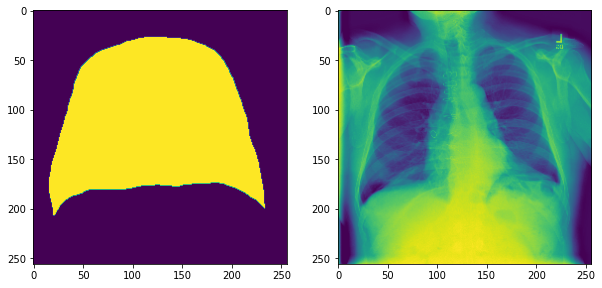

In [22]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [23]:
images.shape

(80, 256, 256, 1)

## Selección de pesos por imagen

Vamos a ver las imagenes y elegir las de peor calidad para darles más peso

In [24]:
# for i in range(len(images)):
#     print(i)
#     plt.figure(figsize=(100, 100))
#     plt.subplot(1,len(images),i+1)
#     plt.imshow(images[i])
#     plt.show()

In [25]:
bad_quality = [14,15,34] + [i for i in range(39,56)] + [65,73,76,77]

In [26]:
importance = np.array([1 if i in bad_quality else 0.75 for i in range(len(images))])

# Aumento de datos

In [29]:
import imutils

In [30]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    return input_image, input_mask

Nuevas imagenes con rotacion random

In [31]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [32]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
importance = np.concatenate((importance, importance), axis=0)

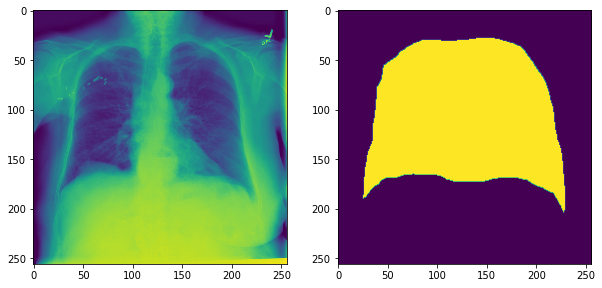

In [33]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [34]:
images.shape

(160, 256, 256, 1)

In [35]:
masks.shape

(160, 256, 256, 1)

# Entrenamiento

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [54]:
batch = 1
epoch = 500

In [55]:
history = model.fit(images,masks,
                    batch_size = batch,
                    epochs = epoch,
                    shuffle = True,
                    sample_weight = importance,
                    validation_split = 0.2)

Epoch 1/500


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/U-Net/conv2d_transpose_3/conv2d_transpose' defined at (most recent call last):
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "D:\Users\maryskal\AppData\Local\Temp\ipykernel_11052\2177127418.py", line 1, in <cell line: 1>
      history = model.fit(images,masks,
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "D:\Users\maryskal\anaconda3\envs\learning_acil\lib\site-packages\keras\backend.py", line 6134, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential/U-Net/conv2d_transpose_3/conv2d_transpose'
OOM when allocating tensor with shape[1,4096,1419600] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential/U-Net/conv2d_transpose_3/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_95189]